In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import time
from torchvision import datasets, transforms
from torch import nn, optim
import warnings
warnings.filterwarnings("ignore")
import torchvision.models as models
import torch, torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def transform(my_x, my_y):
    tensor_x = torch.Tensor(my_x) # transform to torch tensor
    tensor_y = torch.LongTensor(my_y)

    my_dataset = data.TensorDataset(tensor_x,tensor_y) # create your datset
    my_dataloader = data.DataLoader(my_dataset) # create your dataloader
    return my_dataloader
    
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
    logits = resnet18(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [3]:
transform = transforms.ToTensor()
batch_size=64

trainset = datasets.CIFAR10('cifar-10', download=True, train=True, transform=transform)
testset = datasets.CIFAR10('cifar-10', download=True, train=False, transform=transform)

trainset, valset = torch.utils.data.random_split(trainset, [30000, 20000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Extracting cifar-10/cifar-10-python.tar.gz to cifar-10
Files already downloaded and verified


In [14]:
import time
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. * (10 - 0.7 * x)#* math.exp(-x)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)
    return lr_lambda


resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 101
small_start_lr = 1e-4
small_end_lr = 0.03
start_lr = 0.001
end_lr = 0.1
factor = 10
opt = torch.optim.Adam(resnet18.parameters(), lr=start_lr)

#lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len(trainset)/batch_size))
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
lr_lambda = lambda x: math.exp(x * math.log(0.1 * start_lr / end_lr) / (num_epochs * len(trainset)/batch_size))
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

step_size = 4*len(trainset) / batch_size
clr = cyclical_lr(step_size, min_lr=small_start_lr, max_lr=small_end_lr)
small_scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

train_loss = []
val_accuracy = []
losses = []
accs = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5
small_flag = False

for epoch in range(num_epochs):
    start_time = time.time()
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.cpu().numpy())
      

        if small_flag == False:
            scheduler.step()
        else:
            small_scheduler.step()
        opt.zero_grad()

        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)
        lr_find_loss.append(loss)
        
        it += 1
        if loss < 0.001:
          small_flag = True

    resnet18.train(False)
    for (X_batch, y_batch) in valloader:
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
    
    accs.append(np.mean(val_accuracy[-len(valset) // batch_size :]))
        
    if epoch % 10 == 0:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(trainset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
        losses.append(np.array(train_loss).mean())

Epoch 1 of 101 took 25.792s
  training loss (in-iteration): 	1.511310
  validation accuracy: 			45.79 %
Epoch 11 of 101 took 25.637s
  training loss (in-iteration): 	0.127060
  validation accuracy: 			70.56 %
Epoch 21 of 101 took 25.740s
  training loss (in-iteration): 	0.034759
  validation accuracy: 			73.29 %
Epoch 31 of 101 took 25.668s
  training loss (in-iteration): 	0.003217
  validation accuracy: 			74.51 %
Epoch 41 of 101 took 25.644s
  training loss (in-iteration): 	0.001014
  validation accuracy: 			74.81 %
Epoch 51 of 101 took 25.656s
  training loss (in-iteration): 	0.011122
  validation accuracy: 			72.31 %
Epoch 61 of 101 took 25.733s
  training loss (in-iteration): 	0.008517
  validation accuracy: 			74.30 %
Epoch 71 of 101 took 25.863s
  training loss (in-iteration): 	0.001165
  validation accuracy: 			74.76 %
Epoch 81 of 101 took 25.836s
  training loss (in-iteration): 	0.000443
  validation accuracy: 			75.13 %
Epoch 91 of 101 took 25.744s
  training loss (in-iterati

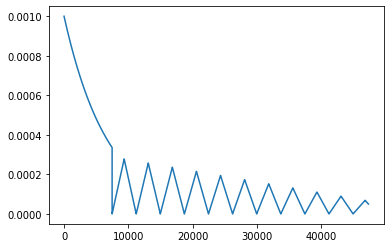

In [15]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

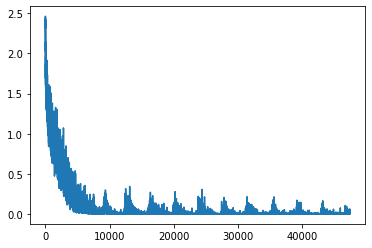

In [16]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()

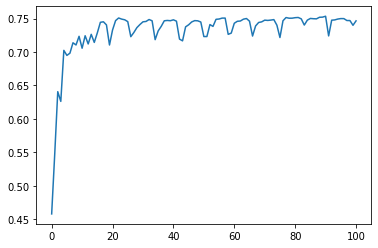

In [17]:
plt.plot(list(range(len(accs))), accs)
plt.show()

In [19]:
import time
import copy
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. * (10 - 0.7 * x)#* math.exp(-x)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)
    return lr_lambda


resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()
models_list = []
prev_model = copy.deepcopy(resnet18)
prev_loss = 1000.


num_epochs = 31
small_start_lr = 1e-4
small_end_lr = 0.03
start_lr = 0.001
end_lr = 0.1
factor = 10
opt = torch.optim.Adam(resnet18.parameters(), lr=start_lr)

#lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len(trainset)/batch_size))
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
lr_lambda = lambda x: math.exp(x * math.log(0.1 * start_lr / end_lr) / (num_epochs * len(trainset)/batch_size))
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

step_size = 4*len(trainset) / batch_size
clr = cyclical_lr(step_size, min_lr=small_start_lr, max_lr=small_end_lr)
small_scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

train_loss = []
val_accuracy = []
losses = []
accs = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5
small_flag = False

for epoch in range(num_epochs):
    start_time = time.time()
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.cpu().numpy())
      

        if small_flag == False:
            scheduler.step()
        else:
            small_scheduler.step()
        opt.zero_grad()

        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)
        lr_find_loss.append(loss)
        
        it += 1
        if loss < 0.001:
          small_flag = True

    resnet18.train(False)
    for (X_batch, y_batch) in valloader:
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
    
    accs.append(np.mean(val_accuracy[-len(valset) // batch_size :]))

    cur_loss = np.mean(train_loss[-len(trainset) // batch_size :])
    if cur_loss - prev_loss > 0.01:
        models_list.append(prev_model)
    prev_model = copy.deepcopy(resnet18)
    prev_loss = cur_loss
    if epoch % 10 == 0:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(trainset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())
      

Epoch 1 of 31 took 26.085s
  training loss (in-iteration): 	1.506056
  validation accuracy: 			48.71 %
Epoch 11 of 31 took 25.958s
  training loss (in-iteration): 	0.026530
  validation accuracy: 			72.85 %
Epoch 21 of 31 took 25.990s
  training loss (in-iteration): 	0.003885
  validation accuracy: 			72.63 %
Epoch 31 of 31 took 25.953s
  training loss (in-iteration): 	0.073865
  validation accuracy: 			70.83 %


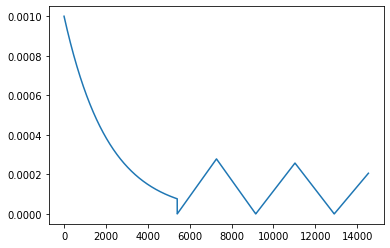

In [20]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

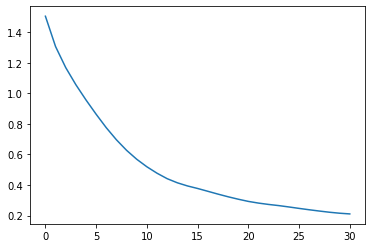

In [21]:
plt.plot(list(range(len(losses))), losses)
plt.show()

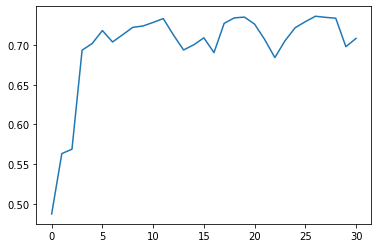

In [22]:
plt.plot(list(range(len(accs))), accs)
plt.show()

In [24]:
len(models_list)

8

In [0]:
from collections import Counter
def ensemble_predictions(members, loader):
    accs = []
    for (X_batch, y_batch) in loader:
        yhats = []
        for model in members:
            y_batch = y_batch.cuda()
            logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
            y_pred = logits.max(1)[1].data
            yhats.append(y_pred.cpu().numpy())
        yhats = np.array(yhats)
        #print(yhats.shape)
        maxs = []
        for i in range(yhats.shape[1]):
            amounts = Counter(yhats[:, i])
            most_freq = amounts.most_common(1)
            maxs.append(most_freq[0][0])
        # sum across ensemble members
        maxs = np.array(maxs)
        #print(maxs.shape)
        # argmax across classes
        accs.append(np.mean((y_batch.cpu().numpy() == maxs)))
    accs = np.array(accs)
    return accs, np.mean(accs)

In [75]:
accs, mean_accs = ensemble_predictions(models_list[3:], valloader)
print(round(mean_accs, 3) * 100, '%')

74.0 %
